In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # matrix construction
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

import pandas as pd
import json
import os

import spacy
import matplotlib
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
from ast import literal_eval
import pandas as pd
import pickle

import sklearn.metrics
import numpy as np

import gensim 
from gensim.models import Word2Vec
import gensim.downloader
from tqdm import tqdm

from sklearn.manifold import TSNE
import nltk

In [2]:
tqdm.pandas()

# Opening Files and Normalisation:

In [3]:
# Open Pickle: 

with open('merged_data_no_duplicates.pickle', 'rb') as handle:
    (X_train_text, X_test_text, Y_train, Y_test, _, _) = pickle.load(handle)
    
    

<AxesSubplot:>

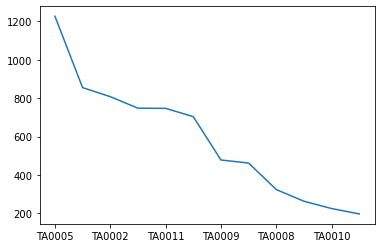

In [6]:
Y_train.sum(axis=0).sort_values(ascending=False).plot()

<AxesSubplot:>

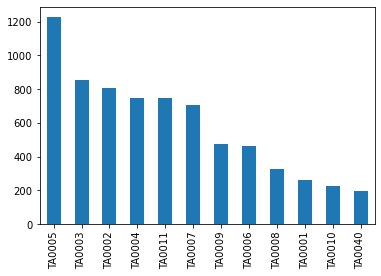

In [7]:
Y_train.sum(axis=0).sort_values(ascending=False).plot(kind='bar')

In [4]:
def feature_extraction(featureExtract, X_train_text, X_test_text, average = False, embedding_type = None):
    if featureExtract in ['CountVectorizer', 'TfIdfVectorizer']:
        if featureExtract == 'CountVectorizer':
            fe = CountVectorizer(analyzer ='word', stop_words ='english', lowercase = True, min_df = 2, max_df = 0.99) # if words used less than 0.001 % and in less than 2 documents --> ignore  
        else:
            fe = TfidfVectorizer(analyzer = 'word', stop_words='english', lowercase=True, min_df = 2, max_df=0.99)
        
        X_train = fe.fit_transform(X_train_text)
        X_train = pd.DataFrame(X_train.toarray(), columns = fe.get_feature_names()) 
        X_test = fe.transform(X_test_text)
        X_test = pd.DataFrame(X_test.toarray(), columns = fe.get_feature_names())
    
    else:
        if embedding_type is None:
            raise ValueError("Missing embedding method")
        model = embedding_type
        # sent is tokenised sentence on which we do the embedding
        def get_embeddings(sent):
            # if text not in vocab:
            words_in_vocab = [word for word in sent if word in model]
            if not words_in_vocab:
                return np.zeros_like(model['the'])
            emb = model[words_in_vocab]
            return np.mean(emb, axis=0) if average else np.sum(emb, axis=0)
        #perform tokenisation
        X_train = pd.DataFrame(X_train_text.progress_apply(nltk.word_tokenize).progress_apply(get_embeddings).values.tolist())
        X_test = pd.DataFrame(X_test_text.progress_apply(nltk.word_tokenize).progress_apply(get_embeddings).values.tolist())
    return X_train, X_test
        
        
        

In [5]:
glv = gensim.downloader.load('glove-wiki-gigaword-100')

In [6]:
X_train, X_test = feature_extraction('embedding', X_train_text, X_test_text, embedding_type = glv)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:01<00:00, 228.11it/s]


In [7]:
Y_train = Y_train.reset_index(drop=True)

In [8]:
# TSNE using vector from glove: 

X = list(X_train.values)
X_embedded = TSNE(n_components=2).fit_transform(X)

df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})

df_embeddings = pd.concat([df_embeddings, Y_train], axis=1)

/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [13]:
df_embeddings

,x,y,TA0006,TA0002,TA0040,TA0003,TA0004,TA0008,TA0005,TA0010,TA0007,TA0009,TA0011,TA0001
0,24.825735,-15.277666,0,0,0,0,0,0,0,0,0,0,0,1
1,-23.600594,20.439962,0,1,0,0,0,0,0,0,0,0,0,1
2,17.264582,-14.127331,0,0,0,0,0,1,0,0,0,0,0,0
3,27.577652,-15.111973,0,0,0,0,1,0,1,0,0,0,0,0
4,2.661252,32.282558,0,1,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,26.354237,34.596722,0,1,0,0,0,0,1,1,1,0,1,0
2068,-13.032504,42.967594,1,1,0,1,1,1,1,0,1,1,1,1
2069,-19.742611,35.697697,0,1,0,1,1,0,1,0,0,0,1,0
2070,-41.359837,4.826746,0,1,0,1,0,0,1,0,1,1,1,0


In [10]:
# Change the tactic id to identify clusters: 

fig = px.scatter(
    df_embeddings, x ='x', y ='y',
    color='TA0001', labels={'color': 'TA0001'},
    hover_data=['x'], title = 'Distribution of reports clustered by vocabulary for tactic TA0001')
fig.show()

# yellow = has tactic
# blue = doesn't have tactic 
# vocabulary associated with this tactic is quite sparse 

In [15]:
Y_test

,TA0006,TA0002,TA0040,TA0003,TA0004,TA0008,TA0005,TA0010,TA0007,TA0009,TA0011,TA0001
319,0,0,0,0,0,0,1,0,0,0,0,0
336,0,0,1,0,0,0,0,0,0,0,0,0
1077,0,1,0,1,1,0,1,0,1,0,0,0
486,0,0,0,0,1,0,1,0,0,0,0,0
371,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1477,0,0,0,1,1,0,0,0,0,0,0,0
1376,0,1,0,1,1,0,0,0,0,0,0,0
415,0,0,0,1,0,0,1,0,0,0,0,0
880,0,0,0,1,0,0,1,0,0,0,1,0
